In [72]:
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import itertools
import collections
import sqlite3
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import random
from collections import Counter
from collections import defaultdict
import copy
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

from scipy.stats import nbinom
from scipy.stats import geom, beta
from scipy.special import logsumexp

sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

/gpfs3/well/band/users/rbx225/GAMCC


# Calling sex lcWGS

      sample    chrX    chrY sex
72   IDT0735  0.6028  0.4858   F
118  IDT0549  0.5612  0.4986   F
160  IDT0498  0.5774  0.4674   F


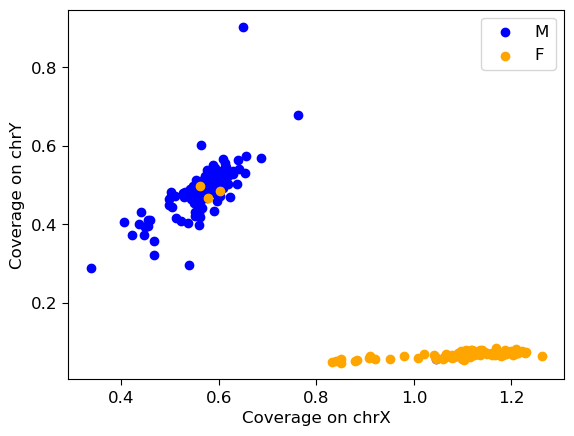

In [2]:
indir = 'results/coverage/sex/'
samples = lcwgsus.read_tsv_as_lst('data/sample_tsvs/fv_idt_names.tsv')

df_lst = []
for i in samples:
    df = pd.read_csv(f'{indir}{i}.sexchr.tsv', sep = '\t', header = None) 
    df.columns = ['sample', 'chrX', 'chrY']
    df_lst.append(df)
df = pd.concat(df_lst).reset_index(drop = True)

metadata = pd.read_csv('data/metadata/sex.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

metadata = metadata[metadata['GMID'].isin(sl['Sample_Name'])]
sl = {k:v for k, v in zip(sl['Sample_Name'], sl['Seq_Name'])}
metadata['GMID'] = metadata['GMID'].apply(lambda x: sl[x])
metadata.columns = ['sample', 'sex']
df = pd.merge(df, metadata, on = 'sample')

labels = ['M', 'F']
colors = ['blue', 'orange']
for i, s in enumerate(labels):
    tmp = df[df['sex'] == s]
    if s == 'F':
        print(tmp[tmp['chrY'] > 0.2])
    plt.scatter(tmp['chrX'], tmp['chrY'], color = colors[i], label = s)
plt.xlabel('Coverage on chrX')
plt.ylabel('Coverage on chrY')
plt.legend()

# Coverage at specific regions

In [57]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)
    
def load_region_files(chunks, chromosome, start, end, indir = 'results/coverage/coverotron/', flank = None):
    chromosome = str(chromosome)
    if flank is not None:
        start = start - flank
        end = end + flank
        
    starts = chunks[chromosome]['start']
    ends = chunks[chromosome]['end']
    
    dfs = []
    for s, e in zip(starts, ends):
        if not (e < start or s > end):  
            file_path = os.path.join(indir, f'chr{chromosome}.{s}.{e}.tsv.gz')
            if os.path.exists(file_path):
                dfs.append(pd.read_csv(file_path, sep='\t', compression = None))
            else:
                print(f"Warning: File {file_path} not found.")

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        raise ValueError("No overlapping files found for the specified region.")
        
def deresolute_windows(df, window_size, normalise = False):
    len_window = int(df.iloc[1,0] - df.iloc[0,0])
    len_region = int(len(df)*len_window)
    if window_size % len_window != 0 or (len_region % window_size) != 0:
        raise ValueError(f"Window size must be a multiple of {len_window} and divide {len_region}.")
    multiple = window_size/len_window
        
    df['window_start'] = (df.iloc[:, 0] // window_size) * window_size
    new_pos = df['window_start'].unique()
    agg_df = df.groupby('window_start').sum().reset_index()
    agg_df['position'] = new_pos
    agg_df = agg_df.drop(columns=['window_start'])
    
    if normalise:
        for s in agg_df.columns[1:]:
            agg_df[s] = agg_df[s]/window_size
    return agg_df

def normalise_by_flank(df, start, end, flank, keep_flank = True):
    fstart = max(start-flank, df.iloc[0,0])
    fend = min(end+flank, df.iloc[-1,0])
    
    flank_cov = df[((df['position'] >= fstart) & (df['position'] < start)) | 
    ((df['position'] > end) & (df['position'] <= fend))].mean(axis = 0).iloc[1:]

    df1 = df.copy()
    for i, s in enumerate(df1.columns[1:]):
        df1[s] = df1[s]/flank_cov.loc[s]
        
    if keep_flank:
        df1 = df1[(df1['position'] >= fstart) & (df1['position'] <= fend)]
    return df1

def get_ticks(df, tick_step):
    df = df.reset_index(drop = True)
    ticks = df['position'].to_numpy()
    if tick_step not in [0.001, 0.01, 0.1, 1]:
        raise ValueError(f"Invalid tick_step: {tick_step}. Choose from 0.001, 0.01, 0.1 or 1.")

    tick_start =ticks[0]
    tick_end = ticks[-1]
    ticks = ticks[np.isclose((ticks / tick_step) % 1, 0)]
    if len(ticks) == 0:
        ticks = [tick_start, tick_end]
    return ticks

## GYP region

### DEL1

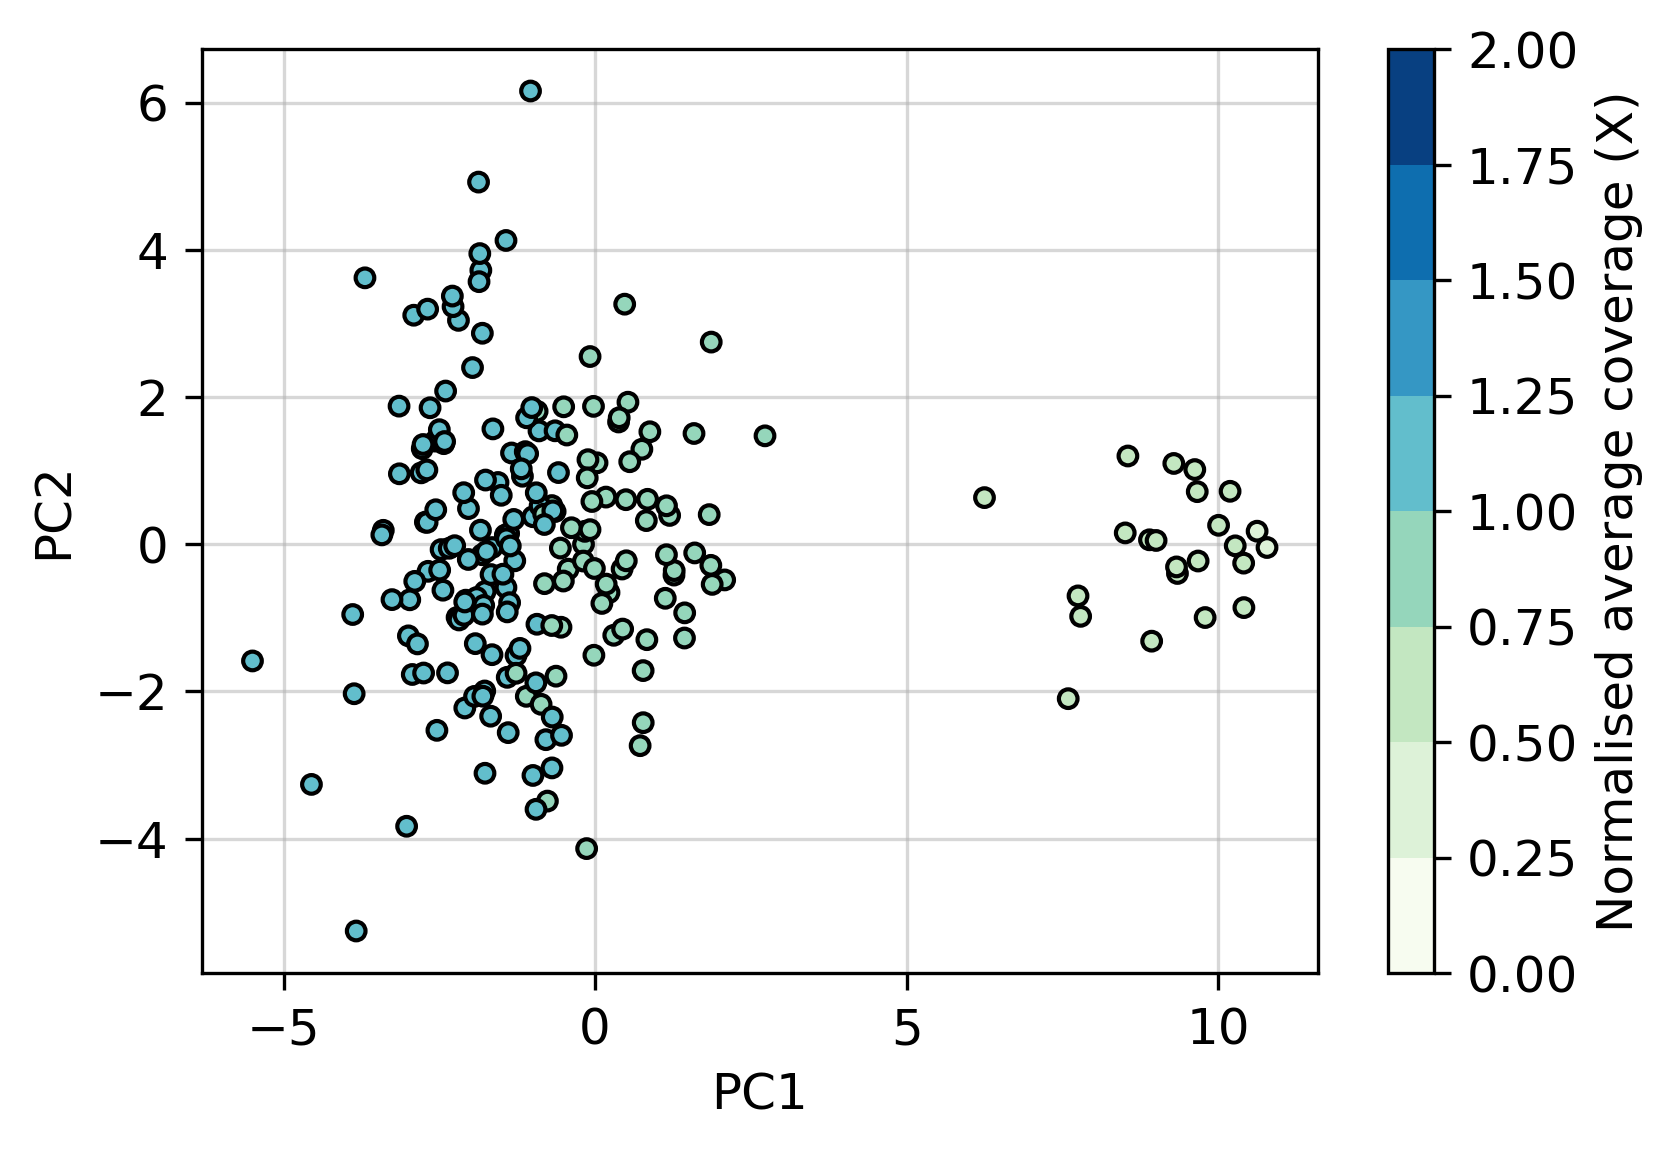

In [228]:
binsize = 1000
chromosome = 4
d1_start = 143910000
d1_end = 144030000
flank = d1_end - d1_start

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['ethnic'] = eth['ethnic']
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, label = e, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

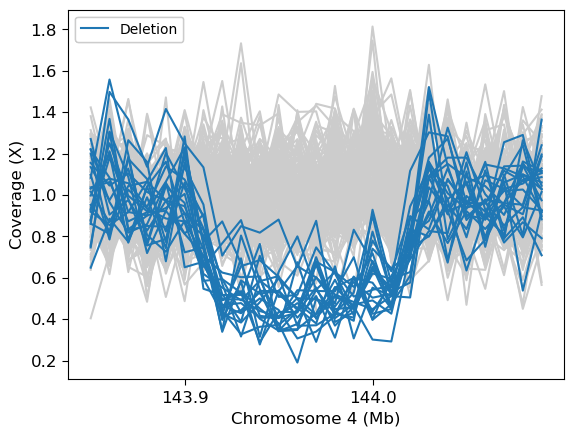

In [230]:
new_window = 10000
tick_step = 0.1
    
cov1 = deresolute_windows(cov, new_window, normalise = True)
del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)
    
ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

### DEL1 by Ethnicities

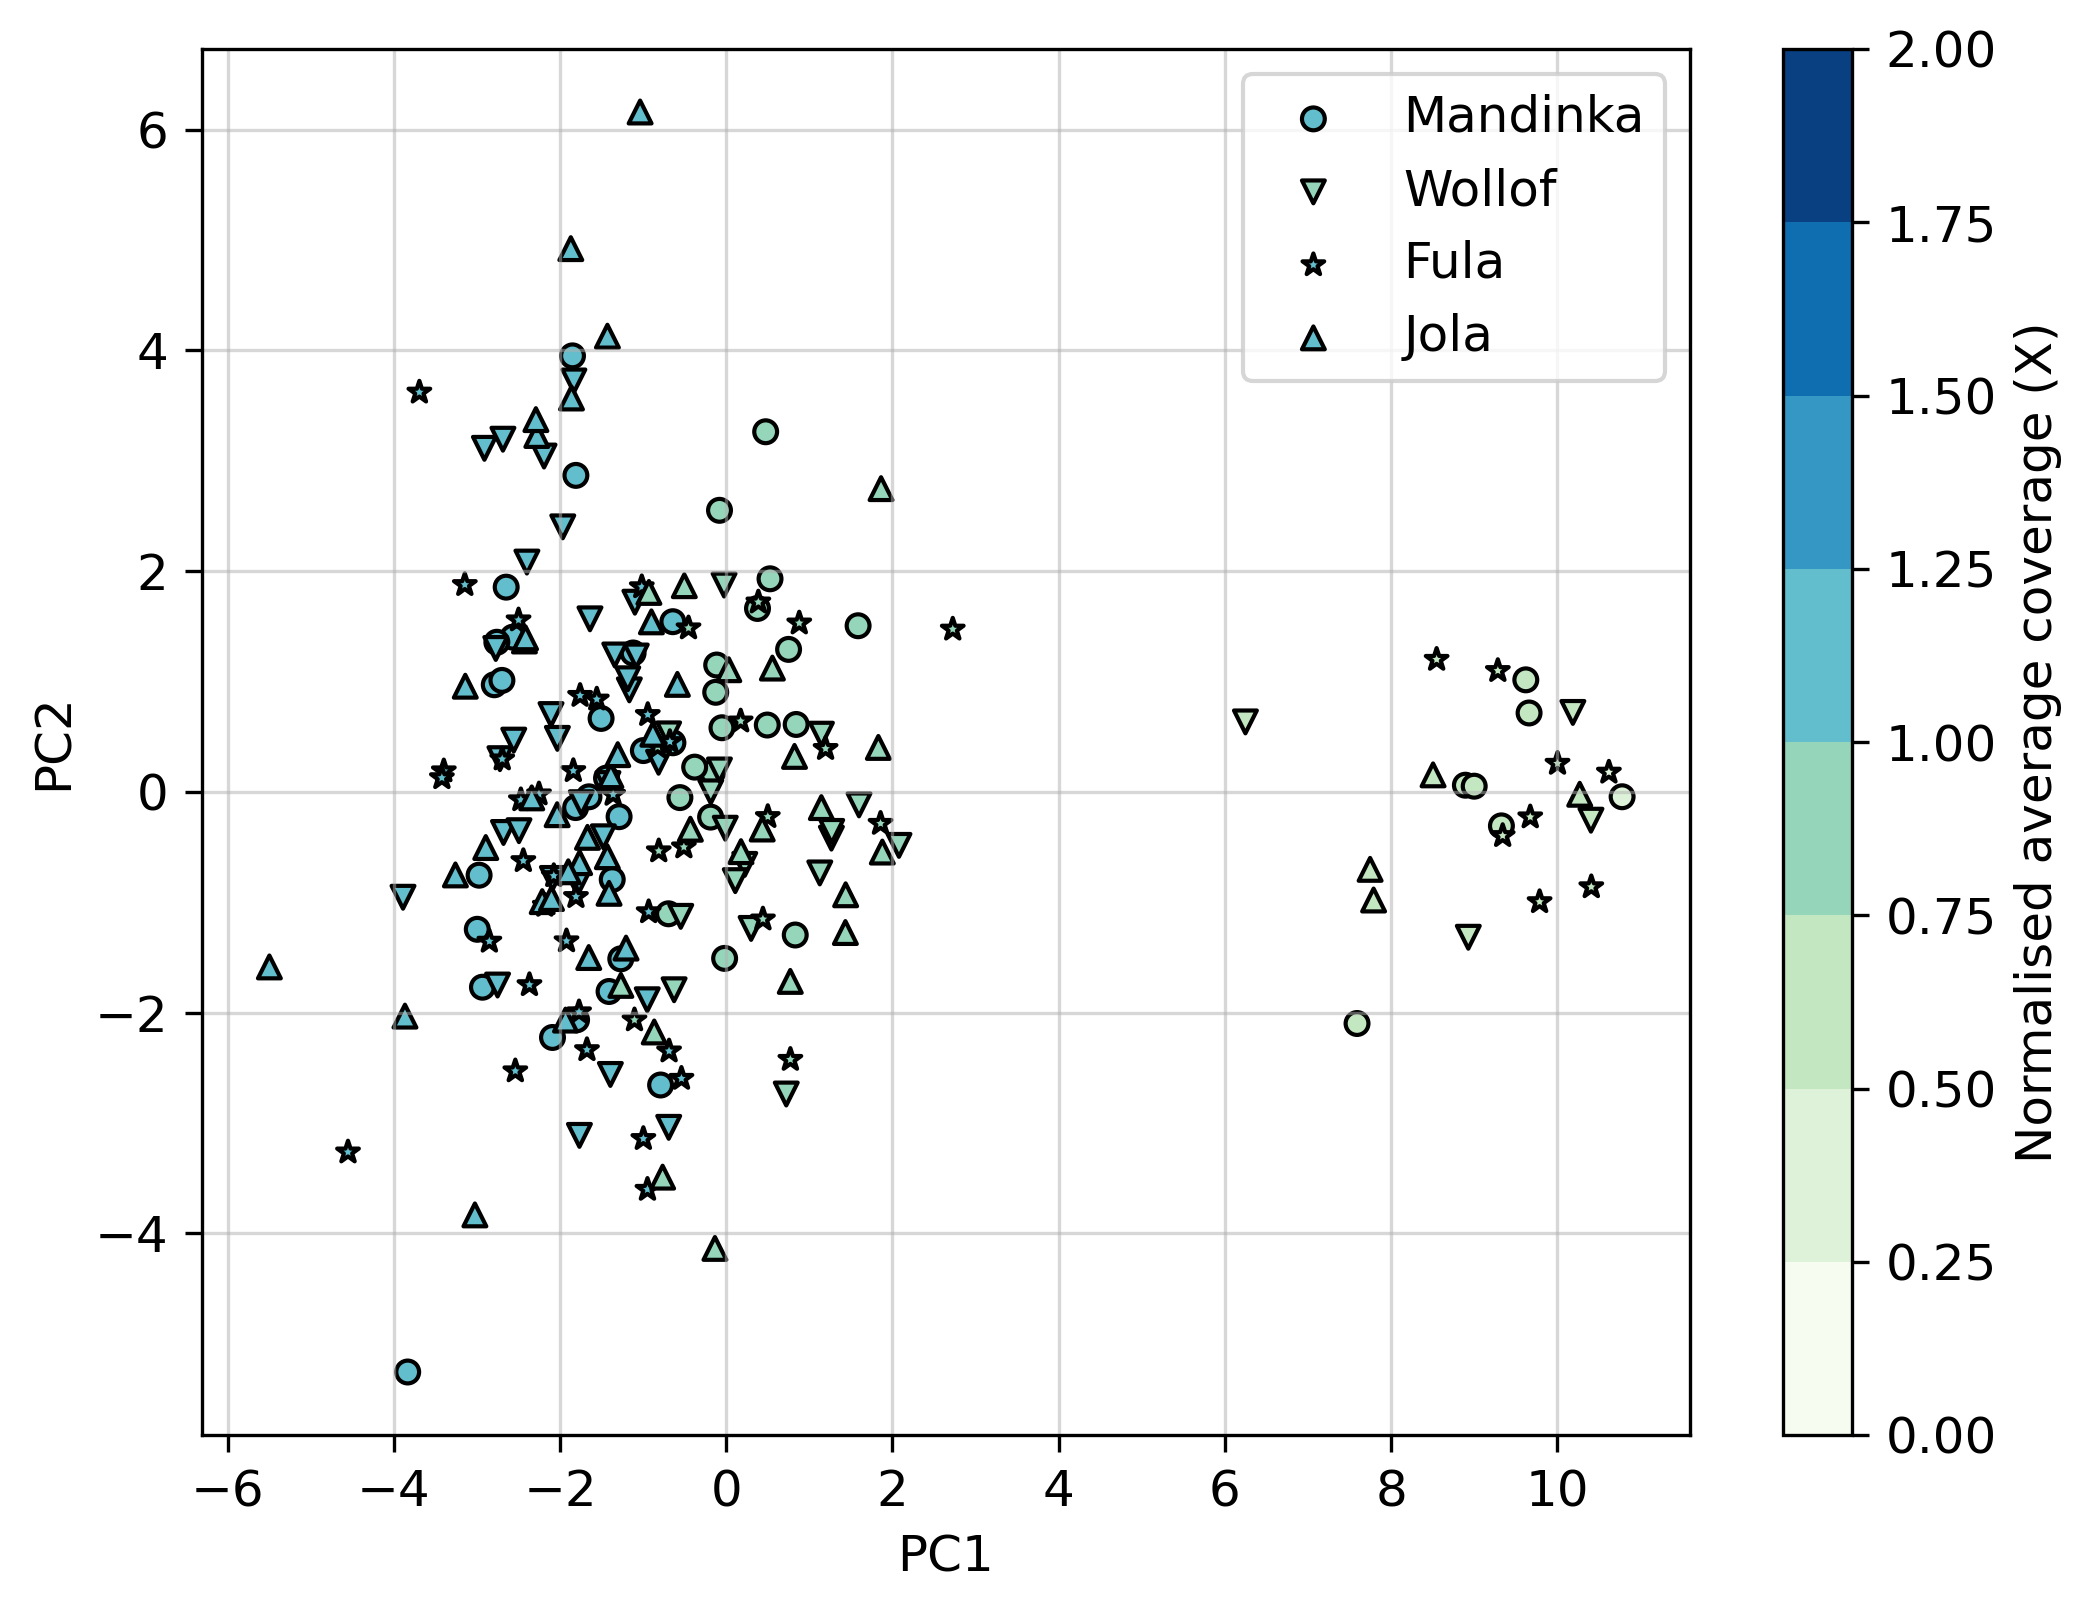

In [28]:
eth = pd.read_csv('data/metadata/ethnic_group.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

eth = eth[eth['Chip_Name'].isin(sl['Chip_Name'])]
sl = {k:v for k, v in zip(sl['Chip_Name'], sl['Seq_Name'])}
eth['Chip_Name'] = eth['Chip_Name'].apply(lambda x: sl[x])
eth = eth.sort_values(by = 'Chip_Name').reset_index(drop = True)
ethnicities = eth['ethnic'].unique().tolist()

flank_cov = cov[((cov['position'] >= d1_start - flank) & (cov['position'] < d1_start)) | 
    ((cov['position'] > d1_end) & (cov['position'] <= d1_end+flank))].mean(axis = 0).iloc[1:]

cov1 = cov.copy()
for i, s in enumerate(cov1.columns[1:]):
    cov1[s] = cov1[s]/(flank_cov.loc[s])

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['ethnic'] = eth['ethnic']
pc_df['cov'] = avg_coverage

markers = ['o', 'v', '*', '^']

fig = plt.figure(figsize=(8, 6), dpi = 300)
for i, e in enumerate(ethnicities):
    tmp = pc_df[pc_df['ethnic'] == e]
    im = plt.scatter(tmp['PC1'], tmp['PC2'], c = tmp['cov'], marker = markers[i], 
                     cmap='GnBu', norm=norm, edgecolor='black', s = 30, label = e)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5)

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DEL2

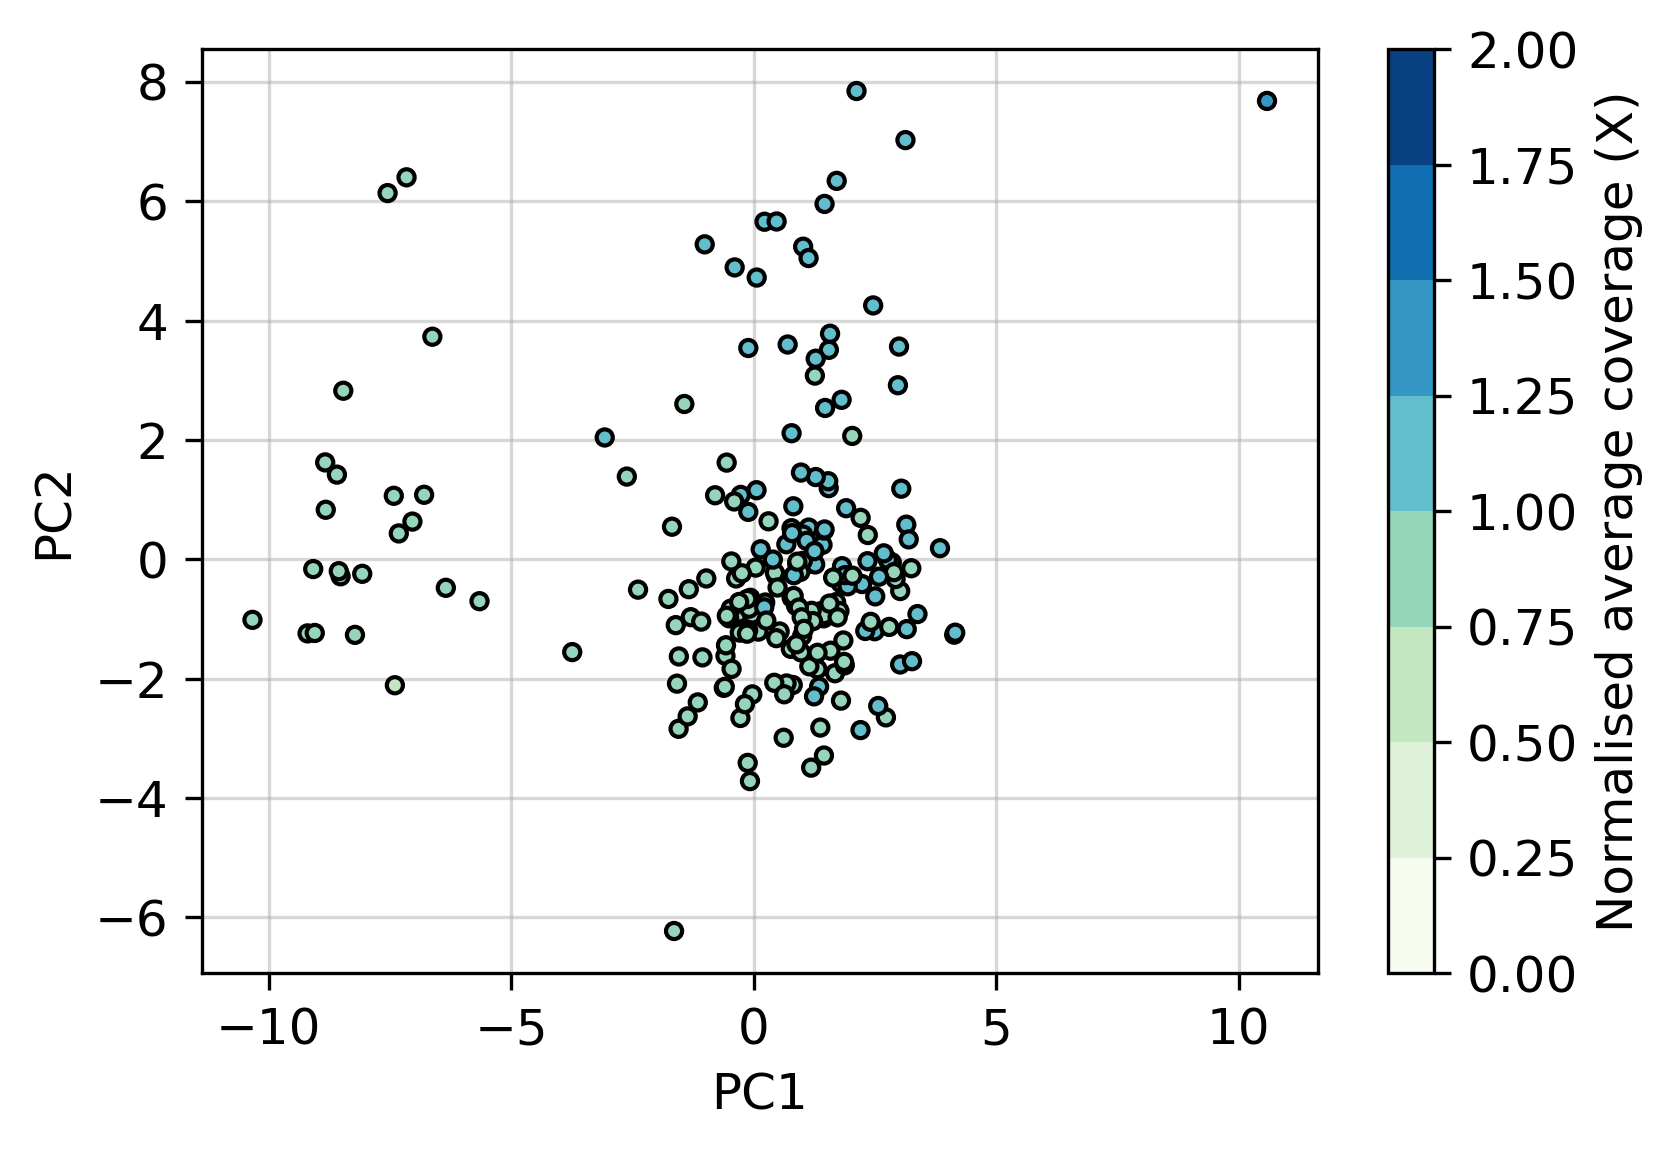

In [172]:
binsize = 1000
chromosome = 4
d1_start = 143780000
d1_end = 143780000 + 210000
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]


fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DUP1

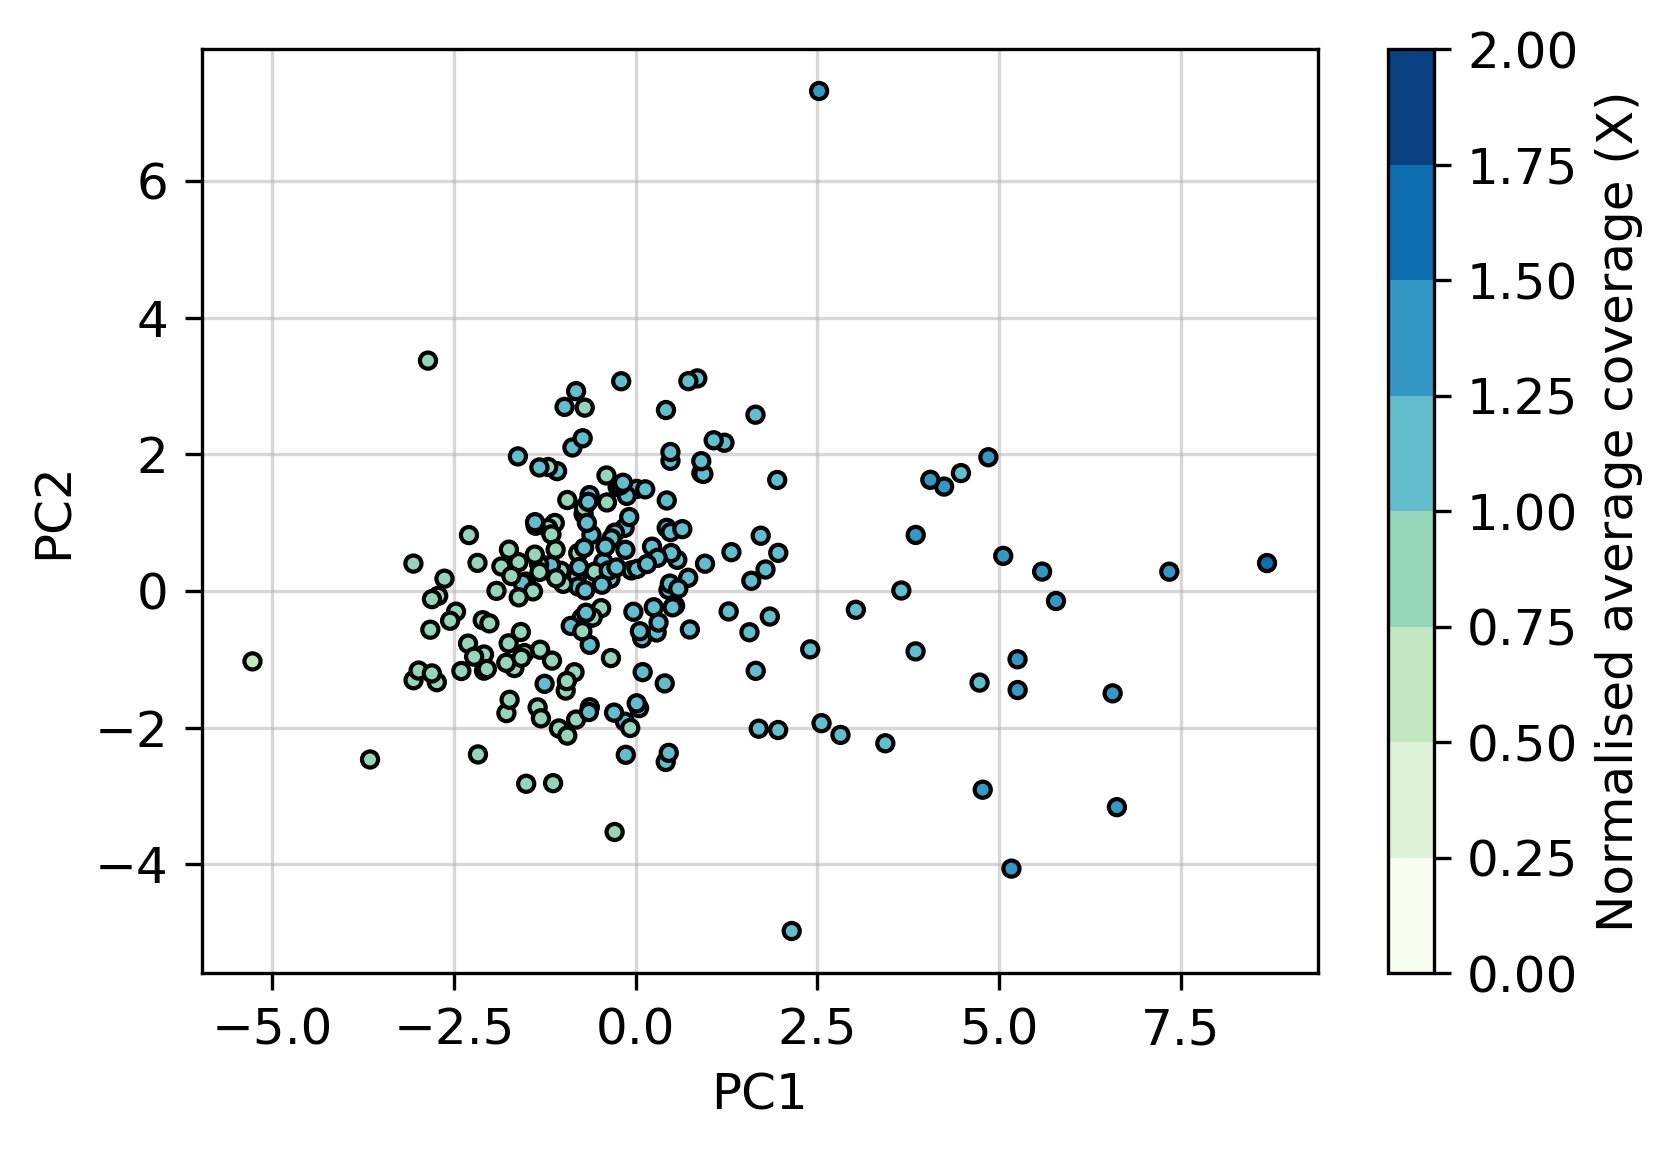

In [232]:
binsize = 1000
chromosome = 4
d1_start = 143790000
d1_end = 143850000
# d1_start = 143778847
# d1_end = 143878847
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]

fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

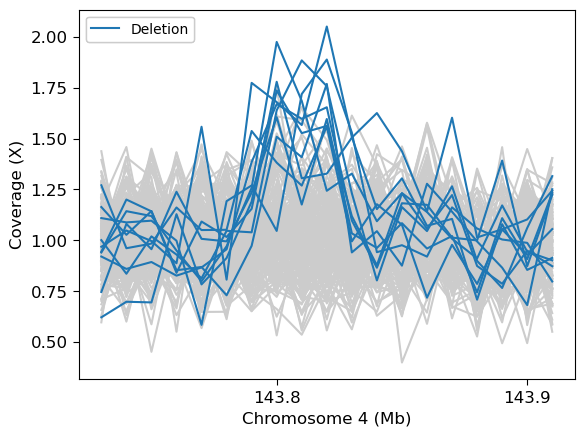

In [233]:
new_window = 10000
cov1 = deresolute_windows(cov, new_window, normalise = True)
tick_step = 0.1
e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)
del1_region = del1_region[(del1_region['position'] >= d1_start - flank) & (del1_region['position'] <= d1_end + flank)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

## HBA region

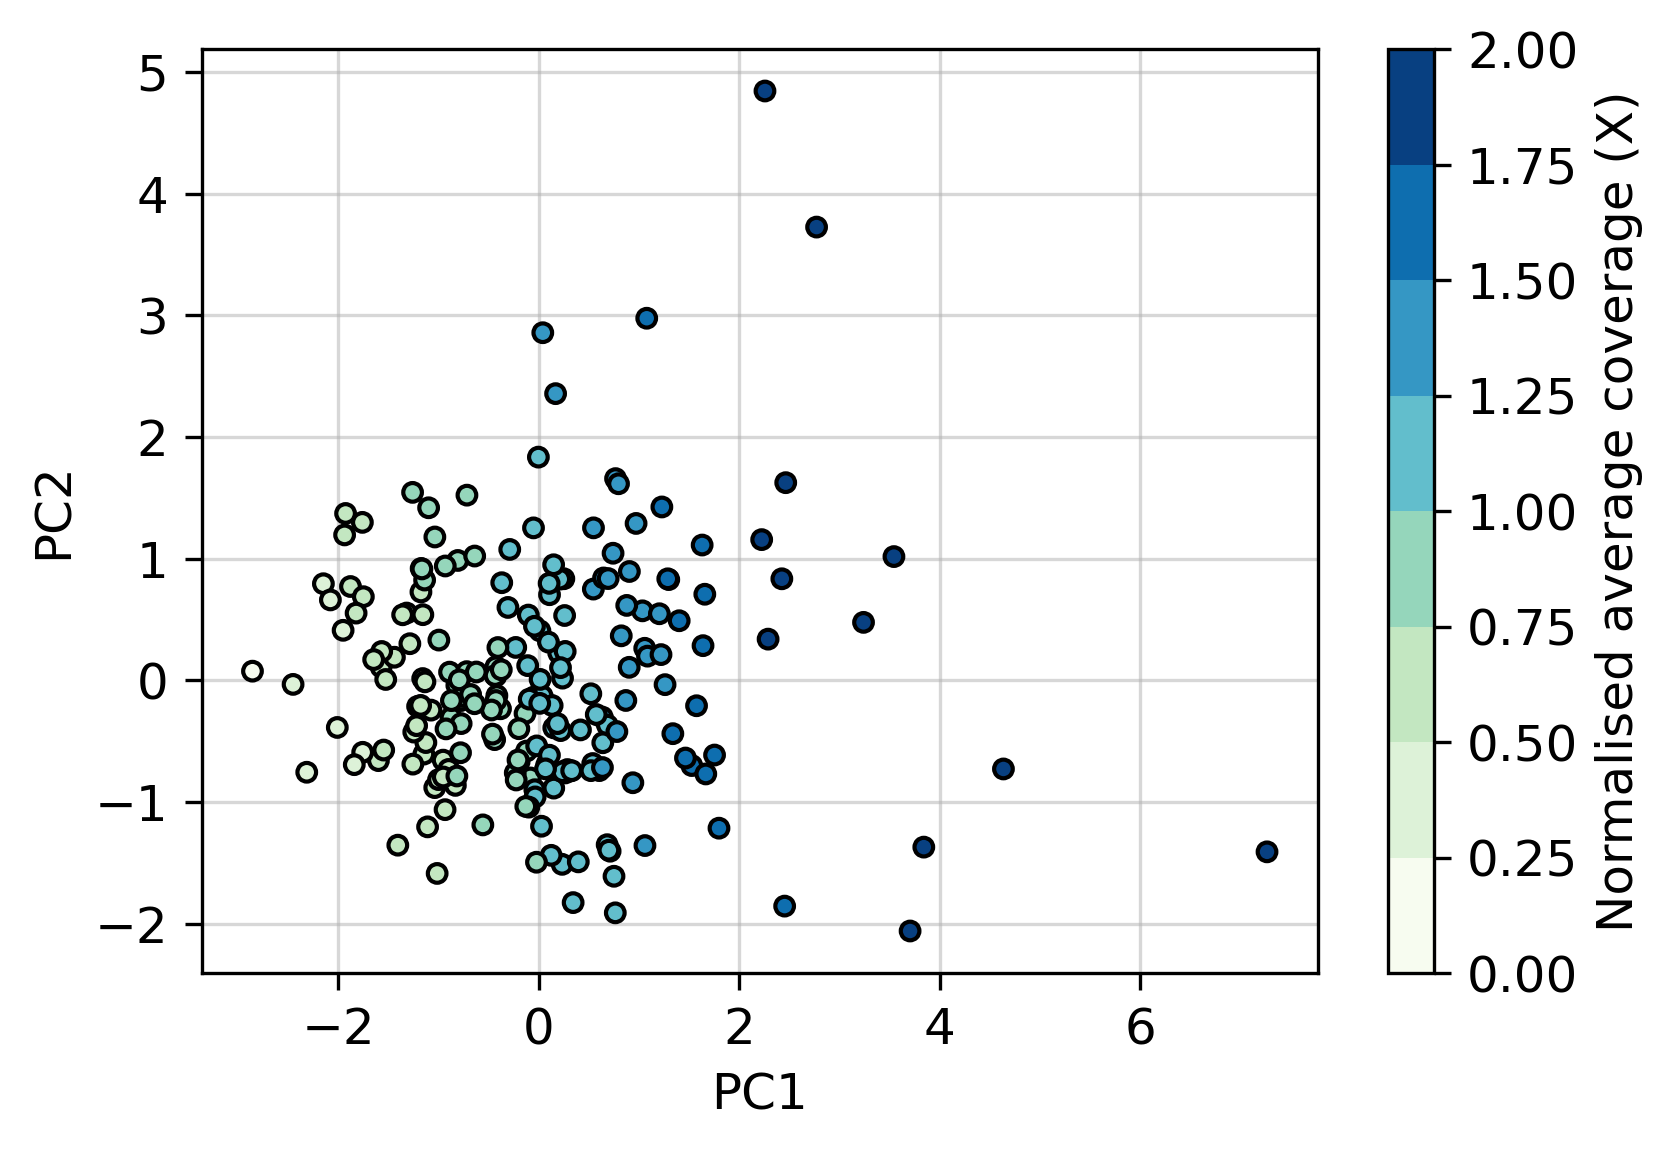

In [67]:
binsize = 300
chromosome = 16
d1_start = 173598
d1_end = 177378
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
# cov = pd.read_csv('results/coverage/specific_regions/HBA.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

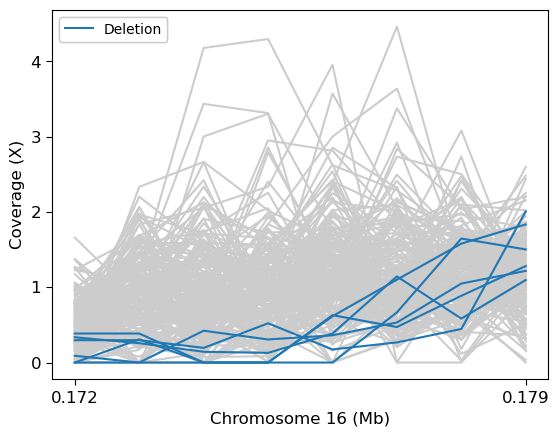

In [68]:
tick_step = 0.001
cutoff = -2

del1_region = cov1

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] >= cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] < cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

# ticks = get_ticks(del1_region, tick_step)
plt.xticks([del1_region.iloc[0,0], del1_region.iloc[-1,0]])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel(f'Chromosome {chromosome} (Mb)')
plt.ylabel('Coverage (X)')

# Genome-wide Coverage

# Nonahore

In [128]:
def read_coverage_data(file_path, sep = ','):    
    df = pd.read_csv(file_path, sep = sep)
    bins = list(zip(df['position'], df['position'] + df['size'], df['N']))
    samples = [col for col in df.columns if col.endswith(":coverage") and col != "total:coverage"]
    coverage = df.loc[:,samples].replace("NA", 0).astype(float).to_numpy()
    samples = [s.split(':')[0] for s in samples]
    return samples, bins, coverage

def load_region_files(chunks, chromosome, start, end, indir = 'results/coverage/coverotron/', flank = None):
    chromosome = str(chromosome)
    if flank is not None:
        start = start - flank
        end = end + flank
        
    starts = chunks[chromosome]['start']
    ends = chunks[chromosome]['end']
    
    dfs = []
    for s, e in zip(starts, ends):
        if not (e < start or s > end):  
            file_path = os.path.join(indir, f'chr{chromosome}.{s}.{e}.tsv.gz')
            if os.path.exists(file_path):
                dfs.append(pd.read_csv(file_path, sep='\t', compression = None))
            else:
                print(f"Warning: File {file_path} not found.")

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        raise ValueError("No overlapping files found for the specified region.")

def precompute_site_lls(means, variances, coverage, max_cnv=10, mismap_proportion = 0.01, model='negative_binomial'):
    L, N = coverage.shape
    site_factor = np.ones(L)
    mismap_propn = np.full(L, mismap_proportion)

    LOG_TWO_PI = np.log(2 * np.pi)
    
    lls = []

    for cn in range(max_cnv):
        mean_term = (
            (means * cn)[np.newaxis, :] * site_factor[:, np.newaxis] +
            means[np.newaxis, :] * mismap_propn[:, np.newaxis]
        )

        if model == 'normal':
            var_term = (
                (variances * cn)[np.newaxis, :] * site_factor[:, np.newaxis] +
                variances[np.newaxis, :] * mismap_propn[:, np.newaxis]
            )
            var_term = np.maximum(var_term, 1e-10)
            residuals = coverage - mean_term
            log_likelihood = (
                -0.5 * LOG_TWO_PI
                - 0.5 * np.log(var_term)
                - 0.5 * (residuals ** 2) / var_term
            )

        elif model == 'negative_binomial':
            mu = mean_term
            var = (
                (variances * cn)[np.newaxis, :] * site_factor[:, np.newaxis] +
                variances[np.newaxis, :] * mismap_propn[:, np.newaxis]
            )
            var = np.maximum(var, mu + 1e-6)
            r = (mu ** 2) / (var - mu)
            p = r / (r + mu)
            x = np.clip(np.round(coverage), 0, None).astype(int)
            log_likelihood = nbinom.logpmf(x, r, p)

        else:
            ValueError("Unsupported model. Choose from: 1.normal; 2.negative_binomial.")
            
        lls.append(log_likelihood)
    return lls

class SVModel:
    def __init__(self, haps=None, freqs=None):
        self.haps = haps
        self.freqs = freqs
    
    def __repr__(self):
        return str(len(self.haps))
    
    def normalise(self):
        tmp = np.array(self.freqs)
        self.freqs = list(tmp/tmp.sum())
    
    def add(self, hap, freq):
        self.haps.append(hap)
        self.freqs = list((1-freq)*np.array(self.freqs))
        self.freqs.append(freq)
        self.normalise()
        
    def replace(self, hap, ix):
        self.haps[ix] = hap
        
def dirichlet_sampling(freqs, concentration = 10):
    alpha = np.array(freqs) * concentration
    rng = default_rng()
    return list(rng.dirichlet(alpha))

def sample_from_freqs(freqs):
    freqs = np.array(freqs)
    cum_probs = np.cumsum(freqs)
    u = np.random.uniform(0, 1)
    return np.searchsorted(cum_probs, u)

def sample_recombinants(model, L, max_cnv = 10):
    hap1 = sample_from_freqs(model.freqs)
    hap2 = sample_from_freqs(model.freqs)
    breakpoints = np.random.choice(np.arange(1, L), size=2, replace=True)
    
    left = model.haps[hap1].copy()
    left[breakpoints[0]:] = 0
    right = model.haps[hap2].copy()
    right[:breakpoints[1]] = 0

    new_hap = left + right
    
    if np.any(new_hap >= max_cnv):
        new_hap = np.ones(L)
    return new_hap

def evaluate_model(model, N, pre_computed_lls, geom_penalty, bin_size = 1000):
    n_haps = len(model.haps)
    L = len(model.haps[0])
    n_diploid = int(n_haps*(n_haps + 1)/2)
    
    dip_model = generate_diploid_profiles(model)
    final_lls = np.zeros((N, n_diploid))
    for i in range(n_diploid):
        ll_ary = evaluate_per_hap(dip_model.haps[i], pre_computed_lls)
        final_lls[:, i] = ll_ary

    final_lls = final_lls + np.log(np.array(dip_model.freqs))[np.newaxis, :] 
    model_ll = logsumexp(final_lls, axis=1).sum()
#     model_ll = model_ll + np.log(geom.pmf(n_haps, geom_penalty))
    model_ll = n_haps*np.log(N*L*bin_size) - 2*model_ll
    return final_lls, model_ll
    
def generate_diploid_profiles(model):
    n_haps = len(model.haps)
    result = SVModel([], [])
    
    for i in range(n_haps):
        for j in range(i, n_haps):
            hap = model.haps[i] + model.haps[j]
            freq = model.freqs[i]*model.freqs[j]*(1+(i!=j))
            
            result.haps.append(hap)
            result.freqs.append(freq)
    result.normalise()
    return result
            
def evaluate_per_hap(hap, pre_computed_lls):
    N = pre_computed_lls[0].shape[1]
    L = pre_computed_lls[0].shape[0]
    
    result = np.zeros(N)
    for i in range(L):
        cn = int(hap[i])
        block = pre_computed_lls[cn]
        result = result + block[i,:]
    return result

def normalise_ll(lls, min_prob=1e-6):
    probs = np.exp(lls - logsumexp(lls, axis=1, keepdims=True))
    
    probs[probs < min_prob] = 0.0
    probs /= probs.sum(axis=1, keepdims=True)
    return probs

def get_best_haps(model, probs):
    N, K = probs.shape
    n_haps = len(model.haps)
    keys = {}
    count = 0
    for i in range(n_haps):
        for j in range(i, n_haps):
            keys[count] = (i, j)
            count += 1
    
    indices = probs.argmax(axis = 1)
    results = [keys[i] for i in indices]
    return results

def sort_model(model):
    haps = model.haps
    freqs = model.freqs
    
    sorted_haps = [hap for hap, _ in sorted(zip(haps, freqs), key=lambda x: x[1], reverse=True)]
    sorted_freqs = [freq for _, freq in sorted(zip(haps, freqs), key=lambda x: x[1], reverse=True)]
    
    return SVModel(sorted_haps, sorted_freqs)

def nonahore(means, variances, covs, samples,
             ploidy = 2, 
             n_iter = 10, 
             n_sample_freq = 200, 
             n_recomb = 1000,
             bin_size = 1000,
             geom_penalty = 0.9,
             max_cnv = 10):
    
    pre_computed_lls = precompute_site_lls(means/ploidy, variances/ploidy, covs)

    L, N = covs.shape

    reference_model = SVModel([np.ones(L)], [1])
    best_model = copy.deepcopy(reference_model)

    best_model_ary = []
    best_ll_ary = []
    best_penalty_ary = []

    for iteration in range(n_iter):
        reference_model = copy.deepcopy(best_model)
        old_haps_set = set()
        models = [reference_model]

        if len(reference_model.haps) > 1:
            for j in range(1, len(reference_model.haps)):
                model = copy.deepcopy(reference_model)
                model.haps = model.haps[:j] + model.haps[(j+1):]
                model.freqs = model.freqs[:j] + model.freqs[(j+1):]
                model.normalise()
                models.append(model)

        if len(reference_model.haps) > 1:
            for _ in range(n_sample_freq):
                model = copy.deepcopy(reference_model)
                model.freqs = dirichlet_sampling(model.freqs)
                model.normalise()
                models.append(model)

        for _ in range(n_recomb):
            new_hap = sample_recombinants(reference_model, L)
            if new_hap.tobytes() in old_haps_set:
                pass
            else:
                old_haps_set.add(new_hap.tobytes())
                for f in np.arange(1,20)*0.05:
                    model = copy.deepcopy(reference_model)
                    model.add(new_hap, f)
                    models.append(model)

                if len(reference_model.haps) > 1:
                    for ix in range(1, len(reference_model.haps)):
                        model = copy.deepcopy(reference_model)
                        model.replace(new_hap,ix)
                        models.append(model)

        _, ref_model_ll = evaluate_model(reference_model, N, pre_computed_lls, geom_penalty)

        best_model = copy.deepcopy(reference_model)
        best_model_ll = ref_model_ll

        for m in models:
            _, model_ll = evaluate_model(m, N, pre_computed_lls, geom_penalty)

            if model_ll < best_model_ll:
                best_model = sort_model(copy.deepcopy(m))
                best_model_ll = model_ll
                reference_model = copy.deepcopy(m)

        best_model_ary.append(reference_model)
        best_ll_ary.append(best_model_ll)

        print(f'------ Iteration {iteration + 1} ------')
        print(f'Best loglikelihood: {best_ll_ary[iteration]}')
    
    lls, _ = evaluate_model(best_model, N, pre_computed_lls, geom_penalty)
    best_probs = normalise_ll(lls)
    best_genotypes = get_best_haps(best_model, best_probs)
    
    results = {}
    results['model_ary'] = best_model_ary
    results['ll_ary'] = best_ll_ary
    results['probs'] = best_probs
    results['genotypes'] = best_genotypes
    return results

def nonahore_adaptive(means, variances, covs, samples,
             ploidy = 2, 
             n_iter = 10, 
             n_sample_freq = 200, 
             n_recomb = 1000,
             bin_size = 1000,
             geom_penalty = 0.9,
             max_cnv = 10):
    
    pre_computed_lls = precompute_site_lls(means/ploidy, variances/ploidy, covs)

    L, N = covs.shape

    reference_model = SVModel([np.ones(L)], [1])
    best_model = copy.deepcopy(reference_model)

    best_model_ary = []
    best_ll_ary = []
    best_penalty_ary = []

    for iteration in range(n_iter):
        this_sample_freq = min(10*iteration, n_sample_freq)
        this_recomb = max(n_recomb - 50*iteration, 0)
        
        reference_model = copy.deepcopy(best_model)
        old_haps_set = set()
        models = [reference_model]

        if len(reference_model.haps) > 1:
            for j in range(1, len(reference_model.haps)):
                model = copy.deepcopy(reference_model)
                model.haps = model.haps[:j] + model.haps[(j+1):]
                model.freqs = model.freqs[:j] + model.freqs[(j+1):]
                model.normalise()
                models.append(model)

        if len(reference_model.haps) > 1:
            for _ in range(this_sample_freq):
                model = copy.deepcopy(reference_model)
                model.freqs = dirichlet_sampling(model.freqs)
                model.normalise()
                models.append(model)

        for _ in range(this_recomb):
            new_hap = sample_recombinants(reference_model, L)
            if new_hap.tobytes() in old_haps_set:
                pass
            else:
                old_haps_set.add(new_hap.tobytes())
                for f in np.arange(1,20)*0.05:
                    model = copy.deepcopy(reference_model)
                    model.add(new_hap, f)
                    models.append(model)

                if len(reference_model.haps) > 1:
                    for ix in range(1, len(reference_model.haps)):
                        model = copy.deepcopy(reference_model)
                        model.replace(new_hap,ix)
                        models.append(model)

        _, ref_model_ll = evaluate_model(reference_model, N, pre_computed_lls, geom_penalty)

        best_model = copy.deepcopy(reference_model)
        best_model_ll = ref_model_ll

        for m in models:
            _, model_ll = evaluate_model(m, N, pre_computed_lls, geom_penalty)

            if model_ll < best_model_ll:
                best_model = sort_model(copy.deepcopy(m))
                best_model_ll = model_ll
                reference_model = copy.deepcopy(m)

        best_model_ary.append(reference_model)
        best_ll_ary.append(best_model_ll)

        print(f'------ Iteration {iteration + 1} ------')
        print(f'Best loglikelihood: {best_ll_ary[iteration]}')
    
    lls, _ = evaluate_model(best_model, N, pre_computed_lls, geom_penalty)
    best_probs = normalise_ll(lls)
    best_genotypes = get_best_haps(best_model, best_probs)
    
    results = {}
    results['model_ary'] = best_model_ary
    results['ll_ary'] = best_ll_ary
    results['probs'] = best_probs
    results['genotypes'] = best_genotypes
    return results

## Simulation

In [101]:
ploidy = 2
geom_penalty = 0.9
max_cnv = 10
n_iter = 10
n_sample_freq = 200
n_recomb = 1000

cov_file = "../software/iorek_sus/example/nonahore/test_1/training_1_to_20.csv"
_, _, covs = read_coverage_data(cov_file)
means = np.mean(covs, axis = 0)
variances = np.var(covs, axis = 0, ddof = 1)
# Instead of loading from a file we can also input the matrix

cov_file = "../software/iorek_sus/example/nonahore/test_1/coverage_1_to_20.csv"
samples, bins, covs = read_coverage_data(cov_file)

results = nonahore(means, variances, covs, samples)

------ Iteration 1 ------
Best loglikelihood: 24489.89192737905
------ Iteration 2 ------
Best loglikelihood: 24328.35344961085
------ Iteration 3 ------
Best loglikelihood: 24309.23729799825
------ Iteration 4 ------
Best loglikelihood: 24308.935866947544
------ Iteration 5 ------
Best loglikelihood: 24247.73743819351
------ Iteration 6 ------
Best loglikelihood: 24247.737437846434
------ Iteration 7 ------
Best loglikelihood: 24247.737437846434
------ Iteration 8 ------
Best loglikelihood: 24247.737437846434
------ Iteration 9 ------
Best loglikelihood: 24247.737437846434
------ Iteration 10 ------
Best loglikelihood: 24247.737437846434


## GYP: DEL1 and DEL2

In [ ]:
bin_size = 1000
chromosome = 4
start = 143890000
end = 144120000
flank = end - start

def normalise_by_flank(df, start, end, flank):
    fstart = max(start-flank, df.iloc[0,0])
    fend = min(end+flank, df.iloc[-1,0])

    cov = df[((df['position'] >= fstart) & (df['position'] < start)) | 
             ((df['position'] > end) & (df['position'] <= fend))].iloc[:,1:-1].to_numpy()
    means = np.mean(cov, axis = 0)
    variances = np.var(cov, axis = 0, ddof = 1)
    return means, variances

def extract_target_cov(df, start, end):
    df = df[(df['position'] >= start) & (df['position'] <= end)].reset_index(drop = True)
    samples = [col for col in df.columns if col.endswith(":coverage") and col != "total:coverage"]
    coverage = df.loc[:,samples].replace("NA", 0).astype(float).to_numpy()
    samples = [s.split(':')[0] for s in samples]
    return samples, coverage

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore_adaptive(means, variances, coverage, samples, n_iter = 20)

------ Iteration 1 ------
Best loglikelihood: 758516.0174762339
------ Iteration 2 ------
Best loglikelihood: 758259.3152791996
------ Iteration 3 ------
Best loglikelihood: 757996.1179596698
------ Iteration 4 ------
Best loglikelihood: 757775.7528912035
------ Iteration 5 ------
Best loglikelihood: 757566.3168281855
------ Iteration 6 ------
Best loglikelihood: 757401.0650848238
------ Iteration 7 ------
Best loglikelihood: 757221.3953073503
------ Iteration 8 ------
Best loglikelihood: 757068.2894532012
------ Iteration 9 ------
Best loglikelihood: 756932.7310770763
------ Iteration 10 ------
Best loglikelihood: 756766.7480943354
------ Iteration 11 ------
Best loglikelihood: 756673.1115696713
------ Iteration 12 ------
Best loglikelihood: 756565.3669695258
------ Iteration 13 ------
Best loglikelihood: 756445.2114637614
------ Iteration 14 ------
Best loglikelihood: 756317.0539066469
------ Iteration 15 ------
Best loglikelihood: 756210.8549012715
------ Iteration 16 ------
Best lo

In [129]:
best_model = results['model_ary'][-1]
N = 210
pre_computed_lls = precompute_site_lls(means/ploidy, variances/ploidy, coverage)
lls, _ = evaluate_model(sort_model(best_model), N, pre_computed_lls, geom_penalty)
best_probs = normalise_ll(lls)
best_genotypes = get_best_haps(best_model, best_probs)